In [1]:
"""
Allow some options on the plots (zoom, resize, save),
/!\: have to wait to the end of the cell's execution
before launch the next
"""
%matplotlib notebook

# standard plot inside the netbook, but no options available
# %matplotlib inline

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join, exists, basename
from scipy.io import wavfile
import pickle
import json
from pprint import pprint
from IPython.display import Audio, display, Markdown
import warnings
import sys
import pandas

import birdsonganalysis as bsa

# utils module from current folder
from utils import (boari_synth_song_error, draw_learning_curve,
                   carac_to_calculate_err_of_synth, err_per_feat)
from cmp_2_sim import plot_gesture_starts

# Allow to import the modules in the model folder
sys.path.append('../model/')
from measures import normalize_and_center, bsa_measure
from song_fitter import SongModel, get_scores
import synth

sns.set_palette('colorblind')

fig_width = 10 # full screen: 16 / half screen: 10
fig_height = 5

In [2]:
# path of the folder with the results
path = '../model/res/'

# -- 1 simulation --
# path += 'seed2+mutate_best_models_elite+512_neg_beta_no_pitch+default_coef_0p+500_diversity_th'

# -- Cluster simulations --
path += 'nlm_div_th_test_180713_173751/'

# -- Definition of each parameter --
# params = []
# params.append("seed0")
# params.append("mutate_best_models_elite")
# params.append("rescal_meas_512")
# params.append("default_coef")
# path += '+'.join(params)

# -- All parameters are defined at the same time --
param_name = "seed3+nlm_div_th_test+0p_1rms+2000_diversity_th"
path += param_name

if exists(join(path, 'aborted.txt')):
    warnings.warn('Aborted run')
if not exists(join(path, 'data.pkl')):
    warnings.warn('Run is not finished')

In [3]:
# load the parameters used for the simulation
with open(join(path, 'conf.json'), 'r') as f:
    run_param = json.load(f)
    
try:
    with open(join(path, 'desc.md'), 'r') as f:
        display(Markdown( '> ' + '\n> '.join(f.read().split("\n"))))
except FileNotFoundError:
    print('No desc for this run.')

No desc for this run.


# Get data

In [4]:
# -- Tutor --
sr, tutor = wavfile.read(join(path, 'tutor.wav'))
tutor = normalize_and_center(tutor)

# -- Songs learned --
outputs = []

try:
    with open(join(path, 'data.pkl'), 'rb') as f:
        songlog = pickle.load(f)
except FileNotFoundError:
    try:
        warnings.warn('Learning not over')
        with open(join(path, 'data_cur.pkl'), 'rb') as f:
            songlog = pickle.load(f)
    except FileNotFoundError:
        print("Error: no data files")
    
root_data = [item[1] for item in songlog if item[0] == 'root']
rd = pandas.DataFrame(root_data)

day_index = -1 # -1: last day

best = np.argmin(rd['scores'].iloc[day_index])
smodels = rd['songs'].iloc[day_index]
sm = smodels[best]
ab = sm.gen_alphabeta()
song = sm.gen_sound()

g_starts = []
for i, gesture in enumerate(sm.gestures):
            g_starts.append(gesture[0])

# Allow to split the gesture on the alpha and beta plots
for start, g in sm.gestures:
    ab[start] = np.nan

In [5]:
print(g_starts)

[0, 866, 1027, 1223, 1407, 1572, 1715, 1855, 1956, 2069, 2349, 2710, 3298, 3582, 3720, 4680, 4991, 5153, 5295, 5723, 6485, 7701, 8804, 9203, 9474, 9649, 9972, 10558, 10658, 12157, 12306, 13040, 13221, 14084, 14225]


In [6]:
print(len(tutor))
print(len(ab))
print(len(song))

19014
19014
19014


<IPython.core.display.Javascript object>


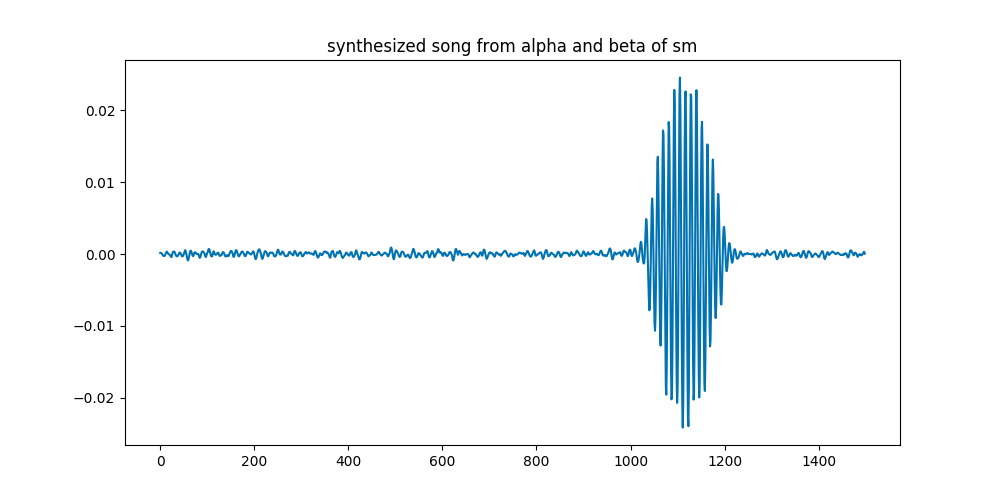

<IPython.core.display.Javascript object>


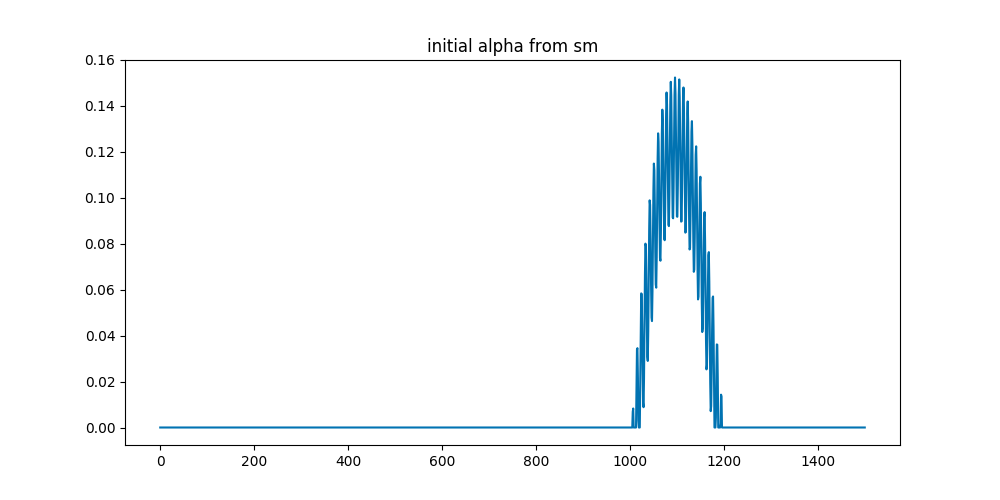

<IPython.core.display.Javascript object>


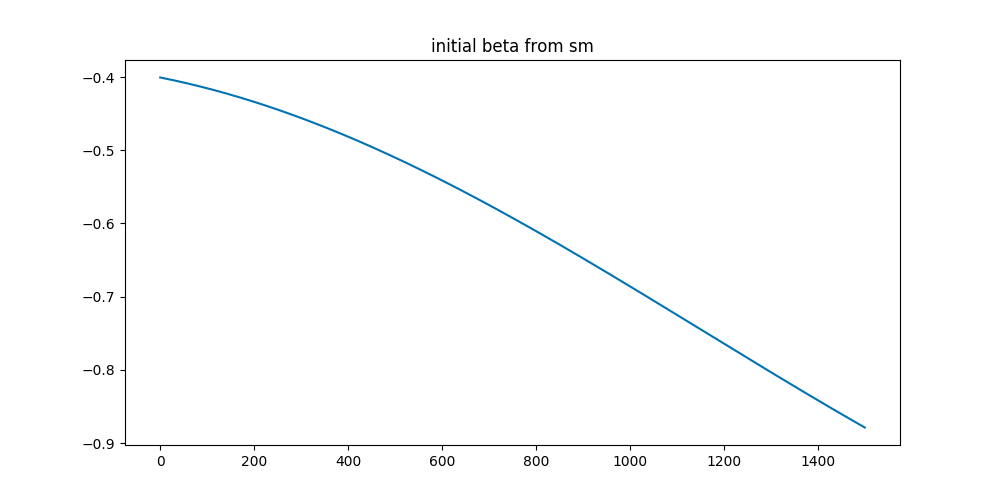

start = 10658
add_at: 11407
end: 12157


<IPython.core.display.Javascript object>


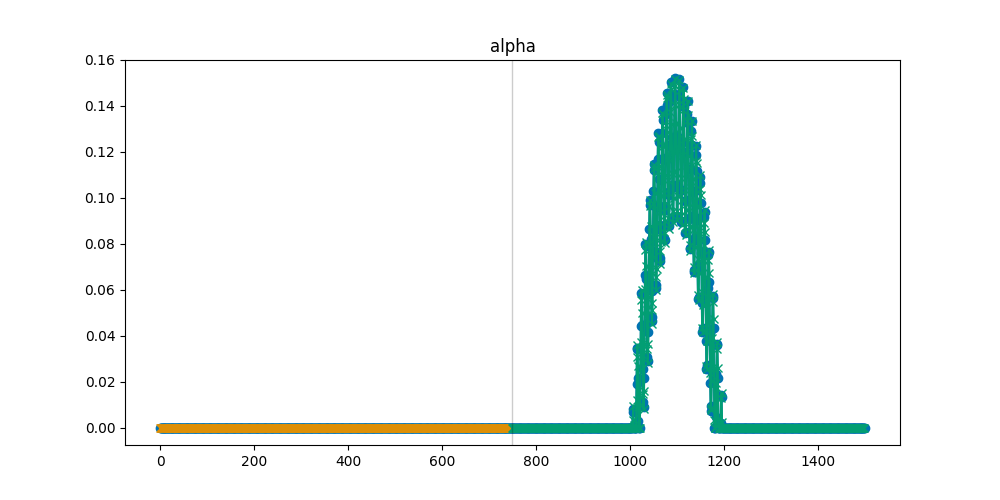

<IPython.core.display.Javascript object>


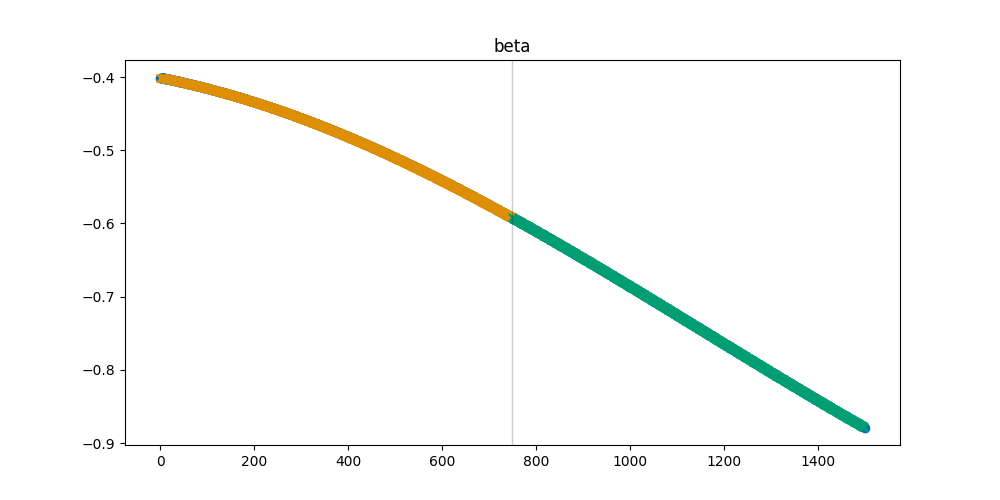

<IPython.core.display.Javascript object>


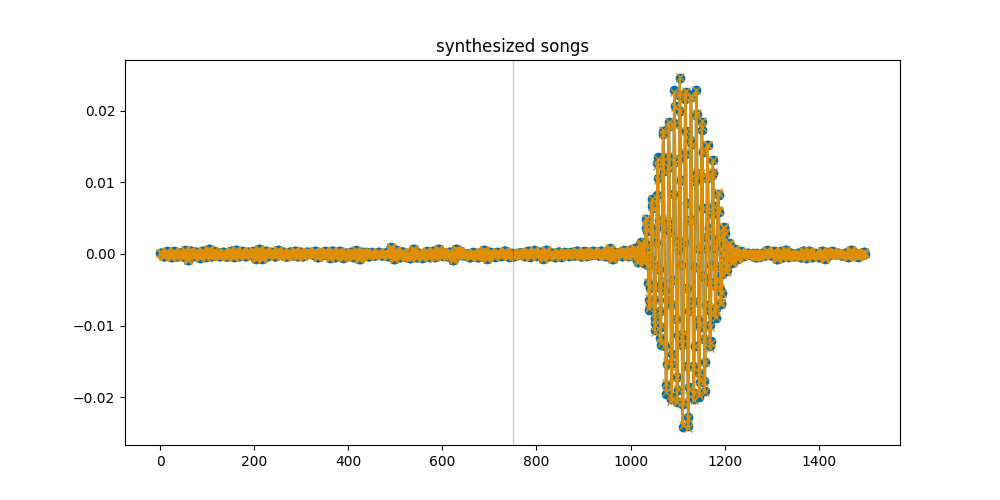

In [7]:
falpha=lambda x, p: synth.only_sin(x, p, nb_sin=3)
fbeta=lambda x, p: synth.only_sin(x, p, nb_sin=1)

index = 28
# out = sm.gen_sound(range_=range(index,index+1))
# plt.figure(figsize=(fig_width, fig_height))
# plt.plot(out)
# plt.title("sm.gen_sound")
# plt.show()

start = sm.gestures[index][0]
end = sm.gestures[index+1][0]
alpha_beta = synth.gen_alphabeta(params=sm.gestures[index][1],
                                 length=end - start,
                                 falpha=falpha,
                                 fbeta=fbeta,
                                 falpha_nb_args=13,
                                 pad='last',
                                 beg=0)

my_out_init = synth.synthesize(alpha_beta, fixed_normalize=True)

plt.figure(figsize=(fig_width, fig_height))
plt.plot(my_out_init)
plt.title("synthesized song from alpha and beta of sm")
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.plot(alpha_beta[:,0])
plt.title('initial alpha from sm')
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.plot(alpha_beta[:,1])
plt.title('initial beta from sm')
plt.show()

add_at = int(start + (end-start) / 2)

print('start =', start)
print("add_at:", add_at)
print('end:', end)

g = sm.gestures[index][1]
t = add_at - start
t /= bsa.SR

new_gesture = deepcopy(g)

# -- Alpha --
# new y-intercepts
for i in [1, 5, 9]:
    new_gesture[i] = g[i-1] * t + g[i] 
# new phase
for i in [2, 6, 10]:
    new_gesture[i] = g[i] + 2 * np.pi * t * g[i+1]

# -- Beta --
# new y-intercept
new_gesture[14] = g[13] * t + g[14]
# new phase
new_gesture[15] = g[15] + 2 * np.pi * t * g[16]

alpha_beta_1 = synth.gen_alphabeta(params=sm.gestures[index][1],
                                 length=add_at - start,
                                 falpha=falpha,
                                 fbeta=fbeta,
                                 falpha_nb_args=13,
                                 pad=False,
                                 beg=0)

alpha_beta_2 = synth.gen_alphabeta(params=new_gesture,
                                 length=end - add_at,
                                 falpha=falpha,
                                 fbeta=fbeta,
                                 falpha_nb_args=13,
                                 pad=False,
                                 beg=0)

x_2 = np.arange(add_at-start, end-start)

plt.figure(figsize=(fig_width, fig_height))
plt.plot(alpha_beta[:,0], 'o-')
plt.plot(alpha_beta_1[:,0], 'x-')
plt.plot(x_2, alpha_beta_2[:,0], 'x-')
plt.axvline(x=add_at-start, color="k", linewidth=1, alpha=0.2)
plt.title('alpha')
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.plot(alpha_beta[:,1], 'o-')
plt.plot(alpha_beta_1[:,1], 'x-')
plt.plot(x_2, alpha_beta_2[:,1], 'x-')
plt.axvline(x=add_at-start, color="k", linewidth=1, alpha=0.2)
# plt.axhline(y=alpha_beta_2[0,1], color="k", linewidth=1, alpha=0.2)
plt.title('beta')
plt.show()

alpha_beta_2_padded = synth.gen_alphabeta(params=new_gesture,
                                 length=end - add_at,
                                 falpha=falpha,
                                 fbeta=fbeta,
                                 falpha_nb_args=13,
                                 pad='last',
                                 beg=0)

glued_gesture = np.concatenate((alpha_beta_1, alpha_beta_2_padded), axis=0)

glued_out = synth.synthesize(glued_gesture, fixed_normalize=True)

plt.figure(figsize=(fig_width, fig_height))
plt.plot(my_out_init, 'o-')
plt.plot(glued_out, 'x-')
plt.axvline(x=add_at-start, color="k", linewidth=1, alpha=0.2)
plt.title("synthesized songs")
plt.show()

In [8]:
sm_mut = deepcopy(sm)
sm_mut.gestures.insert(index+1,
                       [add_at, deepcopy(new_gesture)])

ab_mut = sm_mut.gen_alphabeta()
song_mut = sm_mut.gen_sound()

g_starts_mut = []
for i, gesture in enumerate(sm_mut.gestures):
            g_starts_mut.append(gesture[0])

# Allow to split the gesture on the alpha and beta plots
for start, g in sm_mut.gestures:
    ab_mut[start] = np.nan

<IPython.core.display.Javascript object>


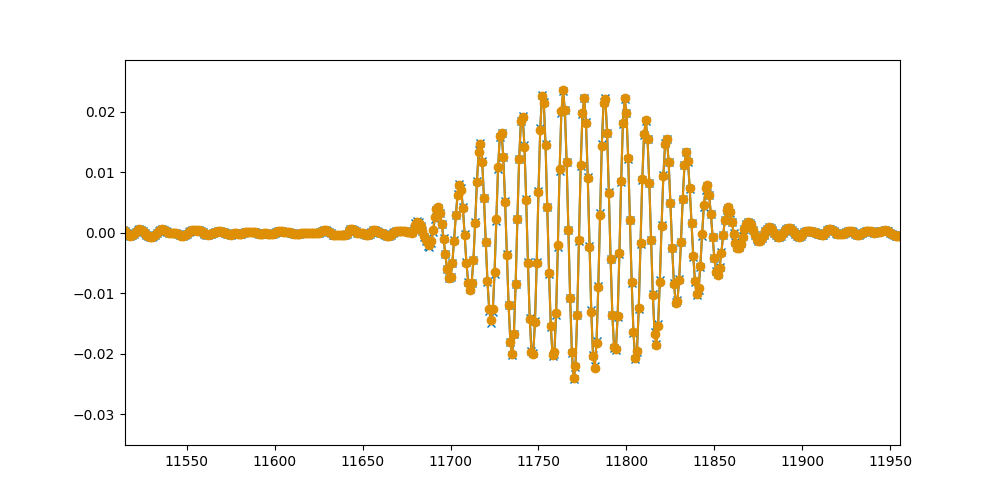

<IPython.core.display.Javascript object>


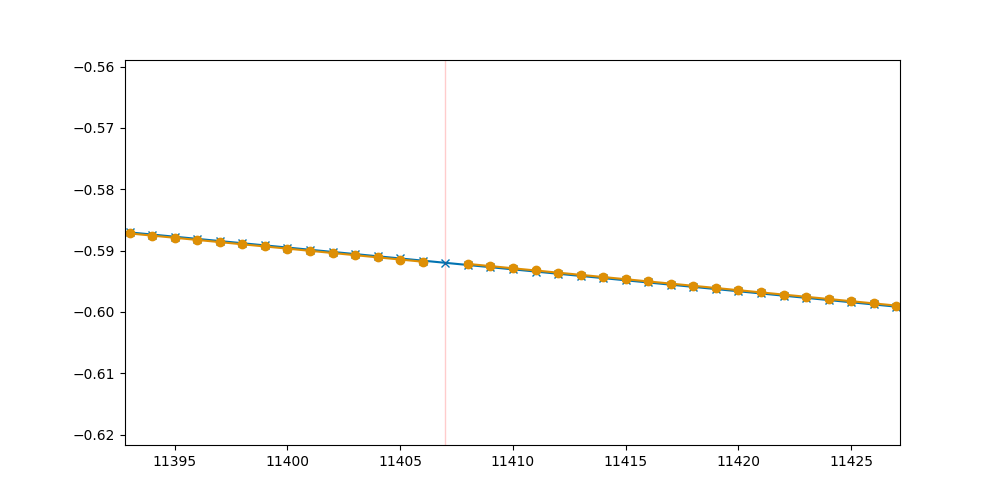

<IPython.core.display.Javascript object>


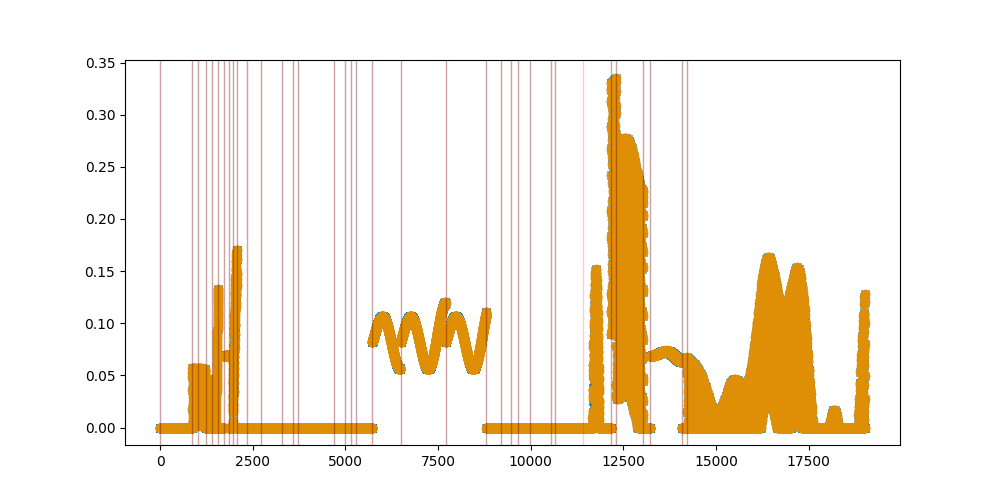

In [9]:
plt.figure(figsize=(fig_width, fig_height))
plt.plot(song, 'x-')
plt.plot(song_mut, 'o-')
plot_gesture_starts(g_starts_mut, color='r')
plot_gesture_starts(g_starts)
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.plot(ab[:,1], 'x-')
plt.plot(ab_mut[:,1], 'o-')
plot_gesture_starts(g_starts_mut, color='r')
plot_gesture_starts(g_starts)
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.plot(ab[:,0], 'x-')
plt.plot(ab_mut[:,0], 'o-')
plot_gesture_starts(g_starts_mut, color='r')
plot_gesture_starts(g_starts)
plt.show()